**Name : `RADHIKA PATWARI`** 

**Roll-No : `18CS10062`** 

**Dept : `Computer Science and Engineering`** 

**Mail-ID : `rsrkpatwari1234@gmail.com & rsrkiwill@iitkgp.ac.in`** 

# Programming Assignment 03
Designed by Abir Das and Omprakash Chakraborty.

This assignment will introduce you to:
1. Building and training a convolutional network
2. Saving snapshots of your trained model
3. Reloading weights from a saved model
4. Fine-tuning a pre-trained network
5. Visualizations using TensorBoardLogger

This code has been tested and should run for Python 3.7.10 with pytorch 1.7.0 and pytorch_lightning 1.2.0 in Google colab. The advantage of colab is that you can use GPUs for small codes that does not need very long runtime.

## Part 0: Tutorials

You will find these tutorials on pytorch and pytorch_lightning useful:
 - [Pytorch Tutorials](https://pytorch.org/tutorials/) - "Deep Learning with PyTorch: A 60 Minute Blitz" is very good starter
 - [Pytorch-lightning masterclass](https://www.youtube.com/playlist?list=PLaMu-SDt_RB5NUm67hU2pdE75j6KaIOv2) - around 140 minutes of videos
 - [deep-learning-project-template](https://github.com/PyTorchLightning/deep-learning-project-template/blob/master/project/lit_image_classifier.py) - You will find this project template from the official pytorch-lightning repo very useful. We have, mostly, tried to follow this template for this assignment.

## Part 1: Building and training a mini-inceptionnet

In [1]:
# Mount your google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# install pytorch lighting
! pip install pytorch-lightning --quiet
#!pip install git+https://github.com/PyTorchLightning/pytorch-lightning fsspec --no-deps --target=$nb_path 

     |████████████████████████████████| 829kB 10.0MB/s 
     |████████████████████████████████| 276kB 21.6MB/s 
     |████████████████████████████████| 829kB 38.1MB/s 
     |████████████████████████████████| 112kB 39.9MB/s 
     |████████████████████████████████| 1.3MB 34.0MB/s 
     |████████████████████████████████| 296kB 41.2MB/s 
     |████████████████████████████████| 143kB 43.2MB/s 


In [3]:
# List of imports
from PIL import Image

## PyTorch
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
## PyTorch lightning
import pytorch_lightning as pl
# Torchvision
import torchvision
from torchvision.datasets import SVHN, CIFAR10
from torchvision import transforms

# import TensorBoardLogger
from pytorch_lightning.loggers import TensorBoardLogger

In the following cell you will create an inception block. The class constructor "\_\_init\_\_" will do that job. The roll of each input argument is written inside the docstring. For your convenience, the well-known inception block architecture is provided here also which shows the use of the two dictionaries "c_bottlenet" and "c_out" more clearly.
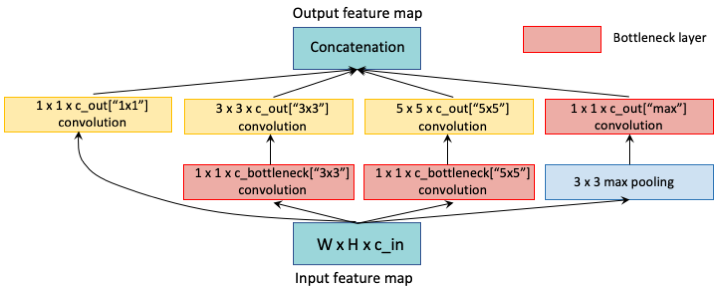

In [4]:
# Lets first create an inception block
class InceptionBlock(nn.Module):
    def __init__(self, c_in : int, c_bottleneck : dict, c_out : dict, act_fn):
        """
        Input argument:
            c_in - Number of input feature maps from the previous layers
            c_bottleneck - Dictionary with keys "3x3" and "5x5" specifying the number of output channels of the 
                           bottleneck layers [1x1 conv]. These are the number of channels of the feature maps that
                           go into subsequent "3x3" and "5x5" conv operations
            c_out - Dictionary with keys "1x1", "3x3", "5x5", and "max". These are the number of output channels
                    after the corresponding conv operations. Note that these are not the bottleneck operations.
                    Also note that "max" does not mean the max pooling operation as such. It actually denotes the
                    bottleneck operation that comes after the max pool operation. Thus, the 'value' corresponding
                    to the "max" key is the number of output channels after the 1x1 bottleneck operation that comes
                    after the max pool operation
            act_fn - Activation function
        """
        super().__init__()
        
        ###################################
        ####   Code required (start)   ####
        ###################################
        # [4+6+6+4 = 20 Marks]
        # NOTE: For all the branches below you should put the batch-norm and activation functions appropriately
        
       
        # Applying convolution -> batchnorm -> activation function
        # https://pytorch.org/docs/1.7.0/generated/torch.nn.Conv2d.html?highlight=conv2d#torch.nn.Conv2d (for my reference)
        # https://www.programmersought.com/article/29286865802/

        # 1x1 convolution branch. Note that no bottlenecking is required
        # W X H X c_in => W X H X c_out["1x1"]
        self.after_conv1x1 = nn.Sequential(
            nn.Conv2d(c_in, c_out["1x1"], kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(c_out["1x1"]),
            act_fn()
        )

        # 3x3 convolution branch. Note that, here, bottlenecking is required
        # W X H X c_in => W X H X c_bottleneck["3x3"] => W X H X c_out["3x3"] 
        self.after_conv3x3 = nn.Sequential(
            nn.Conv2d(c_in, c_bottleneck["3x3"], kernel_size=1, stride=1, padding=0),
            nn.Conv2d(c_bottleneck["3x3"], c_out["3x3"], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(c_out["3x3"]),
            act_fn()
        )

        # 5x5 convolution branch. Note that, here, bottlenecking is required
        # W X H X c_in => W X H X c_bottleneck["5x5"] => W X H X c_out["5x5"] 
        self.after_conv5x5 = nn.Sequential(
            nn.Conv2d(c_in, c_bottleneck["5x5"], kernel_size=1, stride=1, padding=0),
            nn.Conv2d(c_bottleneck["5x5"], c_out["5x5"], kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(c_out["5x5"]),
            act_fn()
        )

        # Max-pool branch. Note that, here, bottlenecking is required
        # W X H X c_in => W X H X c_in => W X H X c_out["max"] 
        self.after_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(c_in, c_out["max"], kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(c_out["max"]),
            act_fn()
        )

        ###################################
        ####    Code required (end)    ####
        ###################################
    
    def forward(self, x):
        # [5 Marks]
        ###################################
        ####   Code required (start)   ####
        ###################################

        # Define the forward pass of the inception block here and return the concatenated activation map

        out_1x1 = self.after_conv1x1(x)  # shape  : N x c_out["1x1"] x H x W  (where N : batchsize)
        out_3x3 = self.after_conv3x3(x)  # shape  : N x c_out["3x3"] x H x W
        out_5x5 = self.after_conv5x5(x)  # shape  : N x c_out["5x5"] x H x W
        out_pool = self.after_pool(x)     # shape  : N x c_out["max"] x H x W
        x = torch.cat([out_1x1, out_3x3, out_5x5, out_pool], dim=1)  # concatinating along channels 
        return x

        ###################################
        ####    Code required (end)    ####
        ###################################

In [6]:
class GoogLeNet(pl.LightningModule):
    def __init__(self, InceptionBlock, act_fn, num_classes=10, learning_rate=1e-3):
        '''
        InceptionBlock: The InceptionBlock class defined above
        act_fn: Is a tuple whose first member is "key" and second one is the "value".
        "key" has to be all lowercase and one of the three options - "relu", "tanh", "leakyrelu".
        "value" has to be correspondingly one of the followings - nn.ReLU, nn.Tanh, nn.LeakyRelu.
        This is required for idiosyncracies in Kaiming_normal initialization.
        num_classes: Number of classes in the dataset which equivalently is the number of output nodes
        learning_rate: The learning rate hyperparameter
        '''
        super().__init__()
        # 'save_hyperparameters' saves the values of anything in the __init__ for us to the checkpoint.
        # This is a useful feature.
        self.save_hyperparameters()
        self.InceptionBlock = InceptionBlock
        # The number of classes present in the dataset
        self.num_classes = num_classes
        self.act_fn = act_fn[1]
        self.act_fn_name = act_fn[0]
        # Calls the network creation method [defined shortly after]
        self._create_network()
        self._init_params()
        self.accuracy = pl.metrics.Accuracy()
    

    def _create_network(self):
        # A first convolution stem network needs to be created which will consist of the following
        # 1. a 3x3 filter with 64 output channels. The output feature map of the stem network will have the same height and width as those of the input
        # 2. Batchnorm
        # 3. activation function [you have to use self.act_fn defined in the constructor]
        ###################################
        ####   Code required (start)   ####
        ###################################
        # [2 Marks]

        in_channel = 3
        out_channel = 64
        self.stem_net = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channel),
            self.act_fn()
        )

        ###################################
        ####    Code required (end)    ####
        ###################################

        # Stacking inception blocks
        self.inception_blocks = nn.Sequential(
            # First stack of two inception blocks
            self.InceptionBlock(64, c_bottleneck={"3x3":16,"5x5":16}, c_out={"1x1":16,"3x3":32,"5x5":8,"max":8}, act_fn=self.act_fn), # 64 --> 64
            self.InceptionBlock(64, c_bottleneck={"3x3":16,"5x5":16}, c_out={"1x1":24,"3x3":56,"5x5":8,"max":8}, act_fn=self.act_fn), # 64 --> 96
            nn.MaxPool2d(3, stride=2, padding=1), # 32x32 --> 16x16
            # Second stack of two inception blocks
            self.InceptionBlock(96, c_bottleneck={"3x3":32,"5x5":16}, c_out={"1x1":24,"3x3":56,"5x5":8,"max":8}, act_fn=self.act_fn), # 96 --> 96
            self.InceptionBlock(96, c_bottleneck={"3x3":32,"5x5":16}, c_out={"1x1":32,"3x3":64,"5x5":16,"max":16}, act_fn=self.act_fn), # 96 --> 128
            nn.MaxPool2d(3, stride=2, padding=1), # 16x16 --> 8x8
            # Third stack which has a single inception block
            self.InceptionBlock(128, c_bottleneck={"3x3":48,"5x5":16}, c_out={"1x1":32,"3x3":64,"5x5":16,"max":16}, act_fn=self.act_fn) # 128 --> 128
        )


        # The final classification layer needs to be created which will consist of the following
        # 1. Average pooling
        # 2. Flattening
        # 3. Appropriate number of output neurons
        ###################################
        ####   Code required (start)   ####
        ###################################
        # [3 Marks]
        self.output_net = nn.Sequential(
            nn.AvgPool2d(kernel_size=(8, 8), stride=1),
            nn.Flatten(start_dim=1),
            nn.Linear(in_features=128, out_features=self.num_classes)
        )
        ###################################
        ####    Code required (end)    ####
        ###################################
    
    # Bit of detail that you can skip. Basically these are standard practice of initialization depending on
    # the type of conv operation and batch-normalization
    def _init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity=self.act_fn_name) # self.hparams.act_fn
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    # Define the forward pass of the inception network
    def forward(self, x):
        # use forward for inference/predictions
        x = self.stem_net(x)
        x = self.inception_blocks(x)
        x = self.output_net(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = F.cross_entropy(logits, y)
        # Logging training loss on each training step and also on each epoch
        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)

        ###################################
        ####   Code required (start)   ####
        ###################################
        # [2 Marks]
        # Here you need to compute the training accuracy and log it in the logger.
        # THE NAME ARGUMENT OF THE LOG() METHOD SHOULD BE 'train_acc'. This is required
        # for the use of it later in wandb. Like the training loss you need to log
        # the training accuracy on each training step and also on each epoch
        self.accuracy(nn.Softmax(dim=1)(logits), y)
        self.log('train_acc', self.accuracy, on_step=True, on_epoch=True, prog_bar=True)  # keep a progressive bar to check evaluation
        ###################################
        ####    Code required (end)    ####
        ###################################

        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = F.cross_entropy(logits, y)
        self.log('val_loss', loss, prog_bar=True)

        ###################################
        ####   Code required (start)   ####
        ###################################
        # [2 Marks]
        # Here you need to compute the validation accuracy and log it in the logger.
        # THE NAME ARGUMENT OF THE LOG() METHOD SHOULD BE 'val_acc'. This is required
        # for the use of it later in wandb. Like the validation loss you need to log
        # the validation accuracy on each epoch but not on each step. Logging it on
        # each step would make the process slow
        self.accuracy(nn.Softmax(dim=1)(logits), y)
        self.log('val_acc', self.accuracy, on_step=False, on_epoch=True, prog_bar=True)   # keep a progressive bar to check evaluation
        ###################################
        ####    Code required (end)    ####
        ###################################

        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = F.cross_entropy(logits, y)
        self.log('test_loss', loss, prog_bar=True)

        ###################################
        ####   Code required (start)   ####
        ###################################
        # [2 Marks]
        # Here you need to compute the test accuracy and log it in the logger.
        # THE NAME ARGUMENT OF THE LOG() METHOD SHOULD BE 'test_acc'. This is required
        # for the use of it later in wandb. Like the test loss you need to log
        # the test accuracy on each epoch but not on each step. Logging it on
        # each step would make the process slow
        self.accuracy(nn.Softmax(dim=1)(logits), y)
        self.log('test_acc', self.accuracy, on_step=False, on_epoch=True, prog_bar=True)   # keep a progressive bar to check evaluation
        ###################################
        ####    Code required (end)    ####
        ###################################

        return loss
    
    def configure_optimizers(self):
        # self.hparams available because we called self.save_hyperparameters()
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)



---
The following cell sets up the dataset with some preliminary data augmentation, the model and the logger. We will first, train our mini-inceptionnet on the [SVHN Dataset](http://ufldl.stanford.edu/housenumbers/).

---




In [7]:
# ------------
# args
# ------------
# Path to the folder where the svhn dataset is/will be downloaded
DATASET_PATH = "/content/drive/MyDrive/svhn"
# Choice of activation functions as dict
act_fn_dict = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "leaky_relu": nn.LeakyReLU
}
# Set the device to gpu, if available, otherwise cpu
# device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# ------------
# data
# ------------
# Download the SVHN dataset. If already downloaded, it will not download again.
# WARNING: NOTE THAT FOR SVHN YOU NEED TO HAVE scipy INSTALLED. INTERNALLY IT IS CALLED.
# LOOK AT - https://chsasank.github.io/vision/_modules/torchvision/datasets/svhn.html
train_dataset = SVHN(root=DATASET_PATH, split='train', download=True)
# As we have learned in the class, it is important to have the data preprocessed with a zero mean
DATA_MEANS = (train_dataset.data / 255.0).mean(axis=(0,2,3))
DATA_STD = (train_dataset.data / 255.0).std(axis=(0,2,3))
print("Data mean", DATA_MEANS)
print("Data std", DATA_STD)
# We will use the mean and standard deviation of the input data computed above to normalize the input.
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# Note that the above normalization will be applied to both test/valiadtion and traning data. The training data,
# in addition, will need to go through a few more data augmentations. We plan to use following data augmentations.
# 1. Random horizontal flip with 50% probability - RandomHorizontalFlip
# 2. Crop the image to random size and aspect ratio. This crop is finally resized to given size - RandomResizedCrop
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.85,1.15)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# Next we will split the training data into training and validation. You will notice that we use the same command
# in the next two lines. This is a trick, often used to make sure that training data uses the random data augmentations
# while validation data do not.
train_dataset = SVHN(root=DATASET_PATH, split='train', transform=train_transform, download=True)
val_dataset = SVHN(root=DATASET_PATH, split='train', transform=test_transform, download=True)
train_set, _ = data.random_split(train_dataset, [60000, 13257])
_, val_set = data.random_split(val_dataset, [60000, 13257])
# Load the test data
test_set = SVHN(root=DATASET_PATH, split='test', transform=test_transform, download=True)
# Define a set of data loaders
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

# ------------
# model
# ------------
activation_used = "leaky_relu"    # check various activation functions
#activation_used = "relu"
#activation_used = "tanh"
model = GoogLeNet(InceptionBlock, act_fn=(activation_used, act_fn_dict[activation_used]))

# ------------
# logging
# ------------
# Initialize Tensorboard logger
TensorBoard_Logger = TensorBoardLogger('/content/drive/MyDrive/tb_logs', 'svhn',activation_used)

# ------------
# training
# ------------
# Initialize a trainer
trainer = pl.Trainer(max_epochs=20,
                    progress_bar_refresh_rate=20, 
                    gpus=1,
                    logger=TensorBoard_Logger)

Using downloaded and verified file: /content/drive/MyDrive/svhn/train_32x32.mat
Data mean [0.4376821  0.4437697  0.47280442]
Data std [0.19803012 0.20101562 0.19703614]
Using downloaded and verified file: /content/drive/MyDrive/svhn/train_32x32.mat
Using downloaded and verified file: /content/drive/MyDrive/svhn/train_32x32.mat
Using downloaded and verified file: /content/drive/MyDrive/svhn/test_32x32.mat


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
GPU available: True, used: True
TPU available: None, using: 0 TPU cores




---
After the setup is complete, lets train!

---




In [8]:
# Train the model
trainer.fit(model, train_loader, val_loader)


  | Name             | Type       | Params
------------------------------------------------
0 | stem_net         | Sequential | 1.9 K 
1 | inception_blocks | Sequential | 137 K 
2 | output_net       | Sequential | 1.3 K 
3 | accuracy         | Accuracy   | 0     
------------------------------------------------
141 K     Trainable params
0         Non-trainable params
141 K     Total params
0.565     Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


1

In [ ]:
# Testing the model
trainer.test(model,test_loader) 
trainer.run_test()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9120697379112244, 'test_loss': 0.29694315791130066}
--------------------------------------------------------------------------------


[{'test_acc': 0.9120697379112244, 'test_loss': 0.29694315791130066}]

Training mini-inceptionnet on SVHN with different activation functions and different epochs.
Complete the following tasks:
1.   Train the network with 3 different activation functions - Tanh, ReLU and LeakyReLU. You will see that a python dictionary __act_fn_dict__ is already provided above for this purpose. Each should be trained for 20 epochs. You do not need to write additional code for this part. You just need to play with the setup code.
2.   Save the three checkpoints above.
3.   Show the evaluation results (i.e., print the validation accuracy and test accuracy) of each of the three checkpoints above.

In the next 3 cells write the code for __step 2 and 3__ for the three activation functions said above.



In [ ]:
! cd /content/drive/MyDrive/tb_logs/svhn/leaky_relu && ls     # checking directory structure

checkpoints
events.out.tfevents.1615312474.47a30e83c7c2.59.0
events.out.tfevents.1615313280.47a30e83c7c2.59.1
events.out.tfevents.1615317359.bba8641188a1.58.0
events.out.tfevents.1615318411.bba8641188a1.58.1
hparams.yaml


In [ ]:
from tensorboard.backend.event_processing import event_accumulator   # importing data container
import os

In [ ]:
###################################
####   Code required (start)   ####
###################################
# [2 Marks]
# Write the code to save the checkpoint
# corresponding to Tanh activation
# function and show the evaluation
# results on validation and test set
# for the same

TensorBoard_Logger.save()
PATH_FOR_CHECKPOINT_FILE = TensorBoard_Logger.experiment.get_logdir() + '/checkpoints/' + 'model.pt'
torch.save({'model_state_dict': model.state_dict(),}, PATH_FOR_CHECKPOINT_FILE)

print(PATH_FOR_CHECKPOINT_FILE)

DIRECTORY = "/content/drive/MyDrive/tb_logs/svhn/tanh/"
for file in os.listdir(DIRECTORY):
    if 'events.out.tfevents.' in file:
        ea = event_accumulator.EventAccumulator(os.path.join(DIRECTORY, file))
        ea.Reload()
        if 'test_acc' in ea.Tags()['scalars']:
          print(ea.Tags())
          print("test_acc=", ea.Scalars('test_acc')[-1][2])
        elif 'val_acc' in ea.Tags()['scalars']:
          print(ea.Tags())
          print("val_acc=", ea.Scalars('val_acc')[-1][2])

###################################
####    Code required (end)    ####
###################################

/content/drive/MyDrive/tb_logs/svhn/tanh/checkpoints/model.pt
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['hp_metric', 'train_loss_step', 'train_acc_step', 'epoch', 'train_loss_epoch', 'train_acc_epoch', 'val_loss', 'val_acc'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
val_acc= 0.894320011138916
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['hp_metric', 'test_loss', 'test_acc', 'epoch', 'val_loss', 'val_acc'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
test_acc= 0.8789950609207153
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['hp_metric', 'train_loss_step', 'train_acc_step', 'epoch', 'train_loss_epoch', 'train_acc_epoch', 'val_loss', 'val_acc'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
val_acc= 0.8777250051498413
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['hp_metric', 'train_loss_ste

In [ ]:
###################################
####   Code required (start)   ####
###################################
# [2 Marks]
# Write the code to save the checkpoint
# corresponding to ReLU activation
# function and show the evaluation
# results on validation and test set
# for the same
TensorBoard_Logger.save()
PATH_FOR_CHECKPOINT_FILE = TensorBoard_Logger.experiment.get_logdir() + '/checkpoints/' + 'model.pt'
torch.save({'model_state_dict': model.state_dict(),}, PATH_FOR_CHECKPOINT_FILE)

print(PATH_FOR_CHECKPOINT_FILE)

DIRECTORY = "/content/drive/MyDrive/tb_logs/svhn/relu/"
for file in os.listdir(DIRECTORY):
    if 'events.out.tfevents.' in file:
        ea = event_accumulator.EventAccumulator(os.path.join(DIRECTORY, file))
        ea.Reload()
        if 'test_acc' in ea.Tags()['scalars']:
            print(ea.Tags())
            print("test_acc=", ea.Scalars('test_acc')[-1][2])
        elif 'val_acc' in ea.Tags()['scalars']:
            print(ea.Tags())
            print("val_acc=", ea.Scalars('val_acc')[-1][2])
            
###################################
####    Code required (end)    ####
###################################

/content/drive/MyDrive/tb_logs/svhn/relu/checkpoints/model.pt
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['hp_metric', 'train_loss_step', 'train_acc_step', 'epoch', 'train_loss_epoch', 'train_acc_epoch', 'val_loss', 'val_acc'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
val_acc= 0.9331673979759216
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['hp_metric', 'test_loss', 'test_acc', 'epoch', 'val_loss', 'val_acc'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
test_acc= 0.919445276260376
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['hp_metric', 'train_loss_step', 'train_acc_step', 'epoch', 'train_loss_epoch', 'train_acc_epoch', 'val_loss', 'val_acc'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
val_acc= 0.9346005916595459


In [ ]:
###################################
####   Code required (start)   ####
###################################
# [2 Marks]
# Write the code to save the checkpoint
# corresponding to LeakyReLU activation
# function and show the evaluation
# results on validation and test set
# for the same
TensorBoard_Logger.save()
PATH_FOR_CHECKPOINT_FILE = TensorBoard_Logger.experiment.get_logdir() + '/checkpoints/' + 'model.pt'
torch.save({'model_state_dict': model.state_dict(),}, PATH_FOR_CHECKPOINT_FILE)

print(PATH_FOR_CHECKPOINT_FILE)

DIRECTORY = "/content/drive/MyDrive/tb_logs/svhn/leaky_relu/"
for file in os.listdir(DIRECTORY):
    if 'events.out.tfevents.' in file:
        ea = event_accumulator.EventAccumulator(os.path.join(DIRECTORY, file))
        ea.Reload()
        if 'test_acc' in ea.Tags()['scalars']:
            print(ea.Tags())
            print("test_acc=", ea.Scalars('test_acc')[-1][2])
        elif 'val_acc' in ea.Tags()['scalars']:
            print(ea.Tags())
            print("val_acc=", ea.Scalars('val_acc')[-1][2])
            
###################################
####    Code required (end)    ####
###################################

/content/drive/MyDrive/tb_logs/svhn/leaky_relu/checkpoints/model.pt
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['hp_metric', 'train_loss_step', 'train_acc_step', 'epoch', 'train_loss_epoch', 'train_acc_epoch', 'val_loss', 'val_acc'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
val_acc= 0.9370898604393005
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['hp_metric', 'test_loss', 'test_acc', 'epoch'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
test_acc= 0.9283574223518372
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['hp_metric', 'train_loss_step', 'train_acc_step', 'epoch', 'train_loss_epoch', 'train_acc_epoch', 'val_loss', 'val_acc'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
val_acc= 0.9356566071510315
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['hp_metric', 'test_loss', 'test_acc', 'epoch

In [ ]:
! cd /content/drive/MyDrive/tb_logs/svhn/leaky_relu/checkpoints/ && ls

'epoch=17-step=8423.ckpt'  'epoch=19-step=9359.ckpt'   model.pt


## Part 2: Loading a pretrained model and finetuning on CIFAR10

In [9]:
# Load the checkpoint which gave the best validation accuracy of the three models you trained above.
# This will be our pretrained model to start with
###################################
####   Code required (start)   ####
###################################
# [1 Mark]
model = GoogLeNet(InceptionBlock, act_fn=("relu",act_fn_dict["relu"]))
model.load_state_dict(torch.load('/content/drive/MyDrive/tb_logs/svhn/leaky_relu/checkpoints/model.pt')['model_state_dict'])
###################################
####    Code required (end)    ####
###################################

<All keys matched successfully>

In [ ]:
# checking parameters
for param in model.state_dict().keys() :
    print(param)

In [10]:
# In this cell write code to freeze stem part and all the inception blocks of the network.
# Just keep the output_net trainable
###################################
####   Code required (start)   ####
###################################
# [3 Marks]

count = 0

# output_net is of form (output_net.2.weight, output_net.2.bias) : exclude this and freeze all other parameters
for name, param in model.named_parameters():
    if not(name.startswith('output_net')):
        param.requires_grad = False
        count = count+1

# counting the number of parameters freezed i.e., 104
print(count)

###################################
####    Code required (end)    ####
###################################

104


In [11]:
# ------------
# CIFAR10 dataset preparation
# ------------
# Path to the folder where the CIFAR-10 dataset is/will be downloaded
DATASET_PATH = "/content/drive/MyDrive/cifar10"
# LOOK AT - https://chsasank.github.io/vision/_modules/torchvision/datasets/cifar.html
train_dataset = CIFAR10(root=DATASET_PATH, train=True, download=True)
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.85,1.15)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)

train_set, _ = data.random_split(train_dataset, [40000, 10000])
_, val_set = data.random_split(val_dataset, [40000, 10000])

test_dataset = CIFAR10(root=DATASET_PATH, train=False,  transform=test_transform, download=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In the next cell, you will write code to fine-tune the model that you loaded a few cells back on cifar-10 for 5 epochs. Note that the TensorBoardLogger is initiated once more here so that the secondary directory to store the logs is 'cifar10' instead of 'svhn'.

In [12]:
# Initialize Tensorboard logger
TensorBoard_Logger = TensorBoardLogger('/content/drive/MyDrive/tb_logs', 'cifar10','leaky_relu')
# Fine-tune the model on CIFAR10 for 5 epochs
###################################
####   Code required (start)   ####
###################################
# [2 Marks]
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

fine_tuner = pl.Trainer(max_epochs=5, progress_bar_refresh_rate=20, gpus=1, logger=TensorBoard_Logger)
fine_tuner.fit(model, train_loader, val_loader)
###################################
####    Code required (end)    ####
###################################

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name             | Type       | Params
------------------------------------------------
0 | stem_net         | Sequential | 1.9 K 
1 | inception_blocks | Sequential | 137 K 
2 | output_net       | Sequential | 1.3 K 
3 | accuracy         | Accuracy   | 0     
------------------------------------------------
1.3 K     Trainable params
139 K     Non-trainable params
141 K     Total params
0.565     Total estimated model params size (MB)


1

In [13]:
###################################
####   Code required (start)   ####
###################################
# Test the fine-tuned model on validation
# and test set and show the evaluation results
# [2 Marks]

fine_tuner.test(model, val_loader)
fine_tuner.run_test()

fine_tuner.test(model, test_loader)
fine_tuner.run_test()

###################################
####    Code required (end)    ####
###################################

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.3862999975681305, 'test_loss': 1.7278331518173218}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.3856000006198883, 'test_loss': 1.7344123125076294}
--------------------------------------------------------------------------------


[{'test_acc': 0.3856000006198883, 'test_loss': 1.7344123125076294}]

In [ ]:
# Show tensorboard plots
%reload_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/tb_logs/